# Robust Principal Component Analysis using the Alternating Direction Method of Multipliers

In [32]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from pdb import set_trace

In [33]:
# Soft Threshold function
def soft(z, lam):     
    return np.sign(z)*np.maximum(np.abs(z)-lam,0) 

ADMM approach solving the Robust PCA problem: 

\begin{align*}
    \min_{\mathbf L,\;\mathbf S}\; \| \mathbf L \|_* \;+\;\lambda \cdot \|\mathbf S\|_1, \quad\text{s.t.}\quad \mathbf Y\;=\;\mathbf L\;+\; \mathbf S,
\end{align*}

The notation here is based on notes from Boyd etal, you may see chapter 3 of https://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf for more information

In [76]:
#ADMM Implementation of Robust PCA
def ADMM(L, S, X, lam, rho, niter=10):
    '''
    Input: 
        L:     Low Rank Component of the Data Matrix 
        S:     The Sparse Component of the Data Matrix
        X:     The Data Matrix
        lam:   The regularization term 
        rho:   Augmented Lagrangian Parameter 
        niter: Number of Iterations 
        
    Intermediate: 
        W:     The scaled Dual variables


    Output: 
        L:     The Low Rank Component of the Data Matrix 
    '''  

    W = np.zeros(L.shape)
    
    out = []
    
    for itr in range(niter):
        # ADMM approach
        
        # Compute SVD of S - X + W/rho
        U, E, V = np.linalg.svd(X - S - W/rho, full_matrices=False)
        
        # Update L based on the soft thresholding of the singular values
        L = (U * soft(E, 1/rho)) @ V

        # Update S
        S = soft(X - L - W/rho, lam/rho)
        
        # Update W
        W = W + rho * (L + S - X)
        
        out.append(L)
    return L, out

In [77]:
## Load the Data 
mnist_49_3000 = sio.loadmat('mnist_49_3000.mat')
x = mnist_49_3000['x']
y = mnist_49_3000['y']
d, n = x.shape
x = x - np.mean(x,axis=1,keepdims=True) #Centering the data 

Rank of original data matrix is: 566
Rank of low rank data matrix is: 286


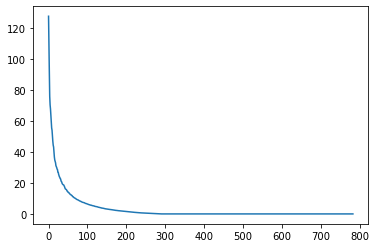

In [79]:
Rho = 1 
ld = 1/np.sqrt(np.amax(x.shape))

x_hat, out_admm =  ADMM(L=x, S=np.zeros(x.shape),X=x, lam=ld, rho = Rho)

print("Rank of original data matrix is: {}".format(np.linalg.matrix_rank(x)))
print("Rank of low rank data matrix is: {}".format(np.linalg.matrix_rank(x_hat)))
U,S,V = np.linalg.svd(x_hat, full_matrices=False)
plt.plot(S)

In [80]:
# Project low rank data matrix (x_hat) to top k left singular vectors of x_hat
k = 50
# Selecting k largest singular values
S_proj = np.zeros(S.shape)
S_proj[:k] = S[:k]
# Projecting the matrix
x_rpca = U * S_proj @ V

ntr = 2000  # number of training points
nts = n - 2000  # number of testing points

x_tilde = np.concatenate([np.ones([1, n]), x_rpca], axis=0)  # append vector of 1 for the bias term

# Split data into training/testing set
xtr = x_tilde[:, :ntr]
xts = x_tilde[:, ntr:]
ytr = y[:, :ntr]
yts = y[:, ntr:]

Regularized logistic regression on the low rank matrix obtained above

In [81]:
#Helper functions

# Define sigmoid function
def sigmoid_func(t):
    return 1. / (1 + np.exp(-t))


# Define derivative of sigmoid function
def sigmoid_func_derive(t):
    return np.exp(-t) / np.square(1 + np.exp(-t))


# Phi (defined in problem 3(a))
def phi(t):
    return np.log(1 + np.exp(-t))



def obj_func(xtr, ytr, lam, theta):
    
    obj_val = np.sum(phi(xtr.T.dot(theta) * ytr.T)) + lam * np.square(np.linalg.norm(theta))
    return obj_val

In [82]:
# Implementation of Gradient Descent
def GD(x, gf, eta, fun=lambda x,itr: 0, niter=100, eps=1e-5):    
    '''
    Input: 
        x:     intilalization 
        gf:    gradient function takes position argument 
        eta:   step size
        fun:   objective value takes position argument 
        niter: number of iterations 
        eps:   tolerance for termination criteria 

    Itermediate: 
        grad:  gradient

    Output: 
        x:     final solution 
        itr:   numer of iteration 
        out:   objective values per iterations 
    '''
    out=np.empty(niter+1)
    out[0] = fun(x,0)
    for itr in range(niter):
        '''
        Gradient Descent
        '''
        x -= eta * gf(x)
        out[itr+1] = fun(x,itr+1)
        if (np.abs(out[itr+1] - out[itr])/np.abs(out[itr])  < eps):
            return x, itr, out[:itr+1]
        itr += 1
    
    out[: itr+1] = fun(x,itr+1)
    return x, itr, out[:itr+1]

In [95]:
# Initialize with the zero vector. +1 for the bias term
lam = 10.0
eps = 1e-5
Niter = 2000 #maximum number of iterations

# Compute the step size
_sum = 0
for i in range(ntr):
    _sum += np.dot(xtr[:,i], xtr[:,i])

L = 2*lam + 0.25*_sum # (2*lambda + 0.25 * sum of )
step_size = 2/(L + 2*lam)

# Gradient function

def grad(z):
    gf = np.zeros([d+1,1])
    gf[:,0] = ( 2 * lam ) * z[:,0]
    for i in range(ntr):
        gf[:,0] -= xtr[:,i] * ytr[:,i][0] / ( 1 + np.exp( ytr[:,i][0] * np.dot(z[:,0], xtr[:,i])))
    return gf
                

#grad = lambda z: ( 2 * lam / ntr ) * z  -  xtr[:,i] * ytr[:,i] / ( 1 + np.exp( ytr[:,i] * np.dot(z[:,0], xtr[:,i]) )

obj = lambda z,itr: obj_func(xtr,ytr,lam, z)

theta, niter, out = GD(np.zeros([d+1,1]), grad, step_size, obj, Niter,eps)

# Logistic regression estimate
y_pred = np.ones([yts.shape[1], 1]) * -1
y_pred[xts.T.dot(theta) >= 0] = 1
test_error = np.sum(y_pred.T != yts) * 100. / float(nts)

print("The test error of the logistic regression classifier is {}".format(test_error))
print("Number of iterations needed: {}".format(niter))

The test error of the logistic regression classifier is 4.9
Number of iterations needed: 437
